In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import copy
import matplotlib.pyplot as plt

from utils import MaskedForward

In [2]:
# Configuración
batch_size = 64
threshold_accuracy = 0.80
sparsity_percentage = 0.2  # Porcentaje de pesos a conservar (más altos)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuración de reinicios organizados en diccionario
restart_checks = {
    7: {"accuracy": 0.50, "message": "VERY EARLY RESTART"},
    # 11: {"accuracy": 0.30, "message": "VERY EARLY RESTART"},
    33: {"accuracy": 0.55, "message": "EARLY RESTART"},
    # 70: {"accuracy": 0.50, "message": "RESTART"}
}

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

data_dir = '../../data/cifar10'

train_dataset = datasets.CIFAR10(root= data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root= data_dir, train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
net = models.alexnet(pretrained=False)
net.classifier[6] = nn.Linear(net.classifier[6].in_features, 10)

mask = models.alexnet(pretrained=False)
mask.classifier[6] = nn.Linear(mask.classifier[6].in_features, 10)

net.to(device)
mask.to(device)

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
# Congelar los parámetros de net (no se entrenarán)
for param in net.parameters():
    param.requires_grad = False

In [6]:
def restart_training():
    """Función para reinicializar net, mask y métricas"""
    global net, mask, optimizer, epoch, losses, accuracies, saved, restart_count
    
    restart_count += 1
    print("Reinicializando net y máscara, y reiniciando el entrenamiento...")
    
    # Reinicializar net (nueva inicialización aleatoria)
    net = models.alexnet(pretrained=False)
    net.classifier[6] = nn.Linear(net.classifier[6].in_features, 10)
    net.to(device)
    
    # Congelar los parámetros de net
    for param in net.parameters():
        param.requires_grad = False
    
    # Reinicializar la máscara
    mask = models.alexnet(pretrained=False)
    mask.classifier[6] = nn.Linear(mask.classifier[6].in_features, 10)
    mask.to(device)
    
    # Reinicializar el optimizador
    optimizer = optim.Adam(mask.parameters(), lr=0.001)
    
    # Reinicializar métricas
    epoch = 0
    losses = []
    accuracies = []
    saved = False

def check_restart_conditions():
    """Verifica todas las condiciones de reinicio usando el diccionario de configuración"""
    current_max_accuracy = max(accuracies) if accuracies else 0
    
    for check_epoch, config in restart_checks.items():
        min_acc = config["accuracy"] * 100
        restart_type = config["message"]
        
        # Para época mayor, verificar si es mayor o igual; para otras, verificar igualdad exacta
        should_check = epoch == check_epoch
        
        if should_check and current_max_accuracy < min_acc:
            print(f"\n!!! {restart_type} {restart_count + 1} !!!")
            print(f"No se alcanzó {min_acc}% de accuracy en época {check_epoch}.")
            restart_training()
            return True
    
    return False

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mask.parameters(), lr=0.001)
epoch = 0
saved = False
losses = []
accuracies = []
restart_count = 0

while True:
    # Verificar condiciones de reinicio
    if check_restart_conditions():
        continue
    
    masked_model = MaskedForward(net, mask, sparsity_percentage).to(device)
    masked_model.train()
    running_loss = 0.0

    epoch += 1
    print(f"\n===== Epoch {epoch} (Restart {restart_count}) =====")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = masked_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    # Evaluación
    masked_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = masked_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    accuracies.append(accuracy)

    print(f"Epoch {epoch}: Avg Loss = {avg_loss:.4f}, Test Accuracy = {accuracy:.2f}%")

    if accuracy >= threshold_accuracy * 100:
        print("Reached target accuracy. Stopping training.")
        if not saved:
            torch.save(net.state_dict(), "./models/net_20.pth")
            torch.save(mask.state_dict(), "./models/mask_20.pth")
            print(f"Models saved")
            saved = True
        else:
            print("Model already saved, skipping save.")
        break


===== Epoch 1 (Restart 0) =====
Epoch 1: Avg Loss = 1.8668, Test Accuracy = 37.56%

===== Epoch 2 (Restart 0) =====
Epoch 2: Avg Loss = 1.6206, Test Accuracy = 43.94%

===== Epoch 3 (Restart 0) =====
Epoch 3: Avg Loss = 1.5444, Test Accuracy = 45.78%

===== Epoch 4 (Restart 0) =====
Epoch 4: Avg Loss = 1.4959, Test Accuracy = 47.26%

===== Epoch 5 (Restart 0) =====
Epoch 5: Avg Loss = 1.4608, Test Accuracy = 48.95%

===== Epoch 6 (Restart 0) =====
Epoch 6: Avg Loss = 1.4353, Test Accuracy = 48.07%

===== Epoch 7 (Restart 0) =====
Epoch 7: Avg Loss = 1.4119, Test Accuracy = 48.70%

!!! VERY EARLY RESTART 1 !!!
No se alcanzó 50.0% de accuracy en época 7.
Reinicializando net y máscara, y reiniciando el entrenamiento...

===== Epoch 1 (Restart 1) =====
Epoch 1: Avg Loss = 1.8489, Test Accuracy = 39.74%

===== Epoch 2 (Restart 1) =====
Epoch 2: Avg Loss = 1.5886, Test Accuracy = 44.56%

===== Epoch 3 (Restart 1) =====
Epoch 3: Avg Loss = 1.4811, Test Accuracy = 48.69%

===== Epoch 4 (Resta

KeyboardInterrupt: 

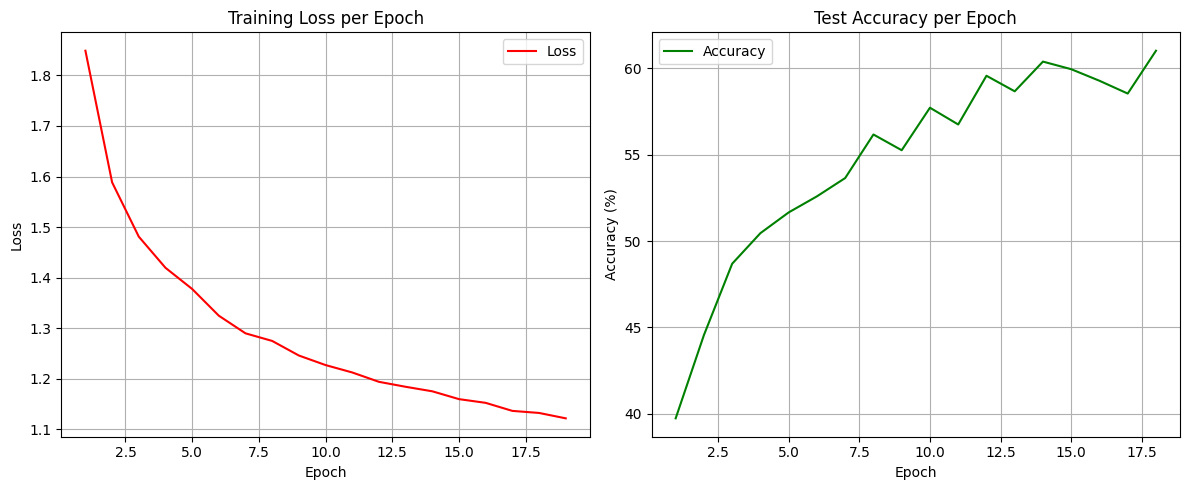

In [8]:
# Gráficos de pérdida y precisión en una sola figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de pérdida
ax1.plot(range(1, len(losses)+1), losses, label='Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss per Epoch')
ax1.legend()
ax1.grid(True)

# Gráfico de precisión
ax2.plot(range(1, len(accuracies)+1), accuracies, label='Accuracy', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy per Epoch')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [9]:
print(losses)
print(len(losses))
print(accuracies)
print(len(accuracies))
print(epoch)

[1.848874525950693, 1.5885628109697796, 1.4811237910214592, 1.4195372064400207, 1.377644088109741, 1.32474895823947, 1.28988735915145, 1.2748596158326435, 1.2460082956897023, 1.2271310233551522, 1.212506094247179, 1.194003682383491, 1.1841898056704674, 1.1752470283557082, 1.1597683745272018, 1.1524154090363046, 1.1365098292412965, 1.1324496053521285, 1.1217817189291006]
19
[39.74, 44.56, 48.69, 50.46, 51.66, 52.59, 53.65, 56.17, 55.26, 57.72, 56.75, 59.57, 58.67, 60.39, 59.95, 59.28, 58.54, 61.02]
18
19
